In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import warnings
warnings.filterwarnings('ignore')

In [3]:
# DATA PREPROCESSING
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

from data_preprocessing import getData

schema, number_of_buildings, number_of_actions, random_seed = getData(
    active_actions=['electrical_storage', 'dhw_storage'],
    number_of_buildings=1,
    number_of_days=7,
    root_path="../../"
)

Active buildings in the schema: 
Building_1


Active observations in the schema: 
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
indoor_relative_humidity
non_shiftable_load
solar_generation
dhw_storage_soc
electricity_pricing
cooling_device_cop
cooling_demand
dhw_demand
cooling_electricity_consumption
dhw_electricity_consumption
indoor_dry_bulb_temperature_delta


Active actions in the schema: 
dhw_storag

In [4]:
from stable_baselines3.common.callbacks import BaseCallback
from citylearn.citylearn import CityLearnEnv

class CustomCallback(BaseCallback):
    def __init__(
        self,
        env: CityLearnEnv,
        trial,
        eval_freq: int = 10000,
        deterministic: bool = True,
    ):

        super().__init__(verbose=0)
        self.env = env
        self.reward_history = [0]
        self.last_mean_reward = 0
        self.learning_rates = []
        self.last_sum_reward = 0

        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False
        self.eval_freq = eval_freq
        self.n_calls = 0


        self.current_timestep = 0
    def _on_step(self) -> bool:
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.last_mean_reward = self.reward_history[-1] / (self.env.time_step + 1)
        self.last_sum_reward = self.reward_history[-1]
        self.n_calls += 1

        self.current_timestep += 1

        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False

        return True

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\citylearn\citylearn.py:31: DeprecationWarning: private variables, such as '_EvaluationCondition__DEFAULT', will be normal attributes in 3.11
  __DEFAULT = ''
C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\citylearn\citylearn.py:32: DeprecationWarning: private variables, such as '_EvaluationCondition__STORAGE_SUFFIX', will be normal attributes in 3.11
  __STORAGE_SUFFIX = '_without_storage'
C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\citylearn\citylearn.py:33: DeprecationWarning: private variables, such as '_EvaluationCondition__PARTIAL_LOAD_SUFFIX', will be normal attributes in 3.11
  __PARTIAL_LOAD_SUFFIX = '_and_partial_load'
C:\Users\Domonkos\AppData\Loc

In [5]:
from typing import Any
from typing import Dict

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
# from stable_baselines3 import SAC
from sbx import DDPG
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
import flax.linen as nn
import numpy as np
from rewardFunctions.rewardFunction3 import CustomRewardFunction

N_TRIALS = 50
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 4
N_TIMESTEPS = 14400
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)


env = CityLearnEnv(schema, central_agent=True)

# set reward function
env.reward_function = CustomRewardFunction(env=env)

# wrap environment
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": env,
    "seed": random_seed
}


def sample_ddpg_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for DDPG hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
    n_critics = trial.suggest_int("n_critics", 1, 5)
    batch_size = trial.suggest_int("batch_size", 64, 512)
    gradient_steps = trial.suggest_int("gradient_steps", 1, 20)
    policy_delay = trial.suggest_int("policy_delay", 1, 48)
    use_sde = trial.suggest_categorical("use_sde", [False, True])
    train_freq = trial.suggest_int("train_freq", 1, 24)
    tau =  trial.suggest_float("tau", 0.0001, 0.1, log=True)
    action_noise_sigma = trial.suggest_float("action_noise_sigma", 0.001, 0.3)
    action_noise = trial.suggest_categorical("action_noise", ["NormalActionNoise", "OrnsteinUhlenbeckActionNoise"])

    # Display true values.
    trial.set_user_attr("gamma_", gamma)

    net_arch = [
        256, 256 if net_arch == "tiny" else 512, 512
    ]
    
    n_actions = number_of_actions * number_of_buildings
    if (action_noise == "NormalActionNoise"):
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=action_noise_sigma * np.ones(n_actions))
    else:
        action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=action_noise_sigma * np.ones(n_actions))

    activation_fn = {"tanh": nn.tanh, "relu": nn.relu}[activation_fn]

    return {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "qf_learning_rate": learning_rate,
        "batch_size": batch_size,
        "gradient_steps": gradient_steps,
        "train_freq": train_freq,
        "tau": tau,
        "action_noise": action_noise,
        "policy_kwargs": {
            "net_arch": net_arch,
            "activation_fn": activation_fn
        },
    }


def objective(trial: optuna.Trial) -> float:
    kwargs = DEFAULT_HYPERPARAMS.copy()
    # Sample hyperparameters.
    kwargs.update(sample_ddpg_params(trial))
    # Create the RL model.
    model = DDPG(**kwargs)

    eval_callback = CustomCallback(env, trial, eval_freq=EVAL_FREQ, deterministic=True)

    nan_encountered = False
    try:
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        # eval_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    
    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward


if __name__ == "__main__":
    # Set pytorch num threads to 1 for faster training.
    torch.set_num_threads(1)

    sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
    # Do not prune before 1/3 of the max budget is used.
    pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_TIMESTEPS // 3)


    study_name = "DDPG_tuning_2024-04-14-1"
    storage_name = "sqlite:///{}.db".format(study_name)
    study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize", study_name=study_name, storage=storage_name)
    try:
        study.optimize(objective, n_trials=N_TRIALS)
    except KeyboardInterrupt:
        pass

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    print("  User attrs:")
    for key, value in trial.user_attrs.items():
        print("    {}: {}".format(key, value))

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\flax\core\meta.py:31: DeprecationWarning: jax.experimental.maps and jax.experimental.maps.xmap are deprecated and will be removed in a future release. Use jax.experimental.shard_map or jax.vmap with the spmd_axis_name argument for expressing SPMD device-parallel computations. Please file an issue on https://github.com/google/jax/issues if neither jax.experimental.shard_map nor jax.vmap are suitable for your use case.
  from jax.experimental import maps
C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  r

Number of finished trials:  1
Best trial:


ValueError: Record does not exist.

## Study evaluation

In [10]:
import optuna

study_name = 'DDPG_tuning_2024-04-21-0'

study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_name}.db")

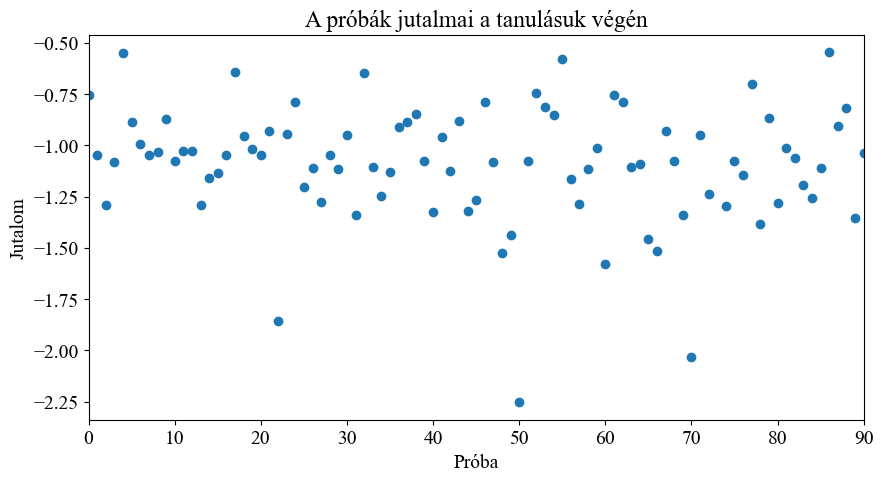

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'font.family': 'Times New Roman'})

study_df = study.trials_dataframe()

plt.figure(figsize=(10, 5))
plt.scatter(study_df.index, study_df['value'])
plt.xlabel('Próba')
plt.ylabel('Jutalom')
plt.title('A próbák jutalmai a tanulásuk végén')
plt.xlim(0, 89)
plt.xticks(range(0, len(study_df), 10), range(0, len(study_df), 10))
plt.show()

In [32]:
study_df.sort_values(by='value', ascending=False, inplace=True)
study_df.drop(columns=["params_use_sde"], inplace=True)
study_df = study_df[study_df["value"].notna()]
study_df

,number,value,datetime_start,datetime_complete,duration,params_action_noise,params_action_noise_sigma,params_activation_fn,params_batch_size,params_gamma,params_gradient_steps,params_lr,params_net_arch,params_tau,params_train_freq,user_attrs_gamma_,state
86,86,-0.545547,2024-04-23 18:37:35.005538,2024-04-23 18:41:46.687471,0 days 00:04:11.681933,OrnsteinUhlenbeckActionNoise,0.106399,relu,317,0.000400,8,0.001971,tiny,0.000410,22,0.999600,COMPLETE
4,4,-0.549053,2024-04-21 13:16:18.051862,2024-04-21 13:24:51.873231,0 days 00:08:33.821369,OrnsteinUhlenbeckActionNoise,0.102406,relu,107,0.071550,11,0.000341,tiny,0.000108,2,0.928450,COMPLETE
55,55,-0.579486,2024-04-22 14:39:16.763233,2024-04-22 14:44:43.245619,0 days 00:05:26.482386,OrnsteinUhlenbeckActionNoise,0.203519,relu,354,0.000979,19,0.000227,tiny,0.000197,21,0.999021,COMPLETE
17,17,-0.641843,2024-04-21 14:44:53.862579,2024-04-21 14:50:33.663557,0 days 00:05:39.800978,OrnsteinUhlenbeckActionNoise,0.001844,relu,328,0.006640,9,0.000920,tiny,0.000473,14,0.993360,COMPLETE
32,32,-0.644926,2024-04-22 12:36:23.318012,2024-04-22 12:41:29.402548,0 days 00:05:06.084536,OrnsteinUhlenbeckActionNoise,0.153022,relu,343,0.000378,13,0.000137,tiny,0.000159,22,0.999622,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,48,-1.523410,2024-04-22 13:59:21.800902,2024-04-22 14:11:01.356876,0 days 00:11:39.555974,OrnsteinUhlenbeckActionNoise,0.207235,relu,291,0.003456,17,0.735458,tiny,0.001008,1,0.996544,COMPLETE
60,60,-1.576721,2024-04-22 15:05:39.090324,2024-04-22 15:10:28.448444,0 days 00:04:49.358120,OrnsteinUhlenbeckActionNoise,0.256346,relu,65,0.000614,9,0.000079,tiny,0.000284,19,0.999386,COMPLETE
22,22,-1.857464,2024-04-21 15:08:20.550436,2024-04-21 15:13:55.301153,0 days 00:05:34.750717,OrnsteinUhlenbeckActionNoise,0.040488,relu,344,0.006099,5,0.000065,tiny,0.000447,4,0.993901,COMPLETE
70,70,-2.031308,2024-04-22 16:02:35.838574,2024-04-22 16:10:53.064412,0 days 00:08:17.225838,OrnsteinUhlenbeckActionNoise,0.088623,relu,124,0.000647,20,0.000548,tiny,0.000594,2,0.999353,COMPLETE


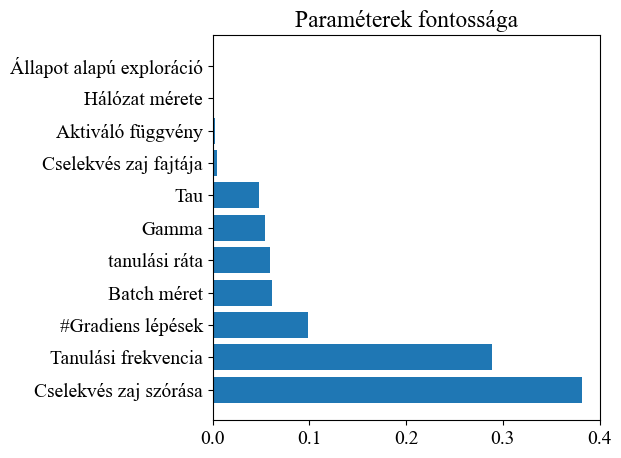

In [33]:
importances = optuna.importance.get_param_importances(study=study, evaluator=optuna.importance.FanovaImportanceEvaluator(n_trees=64, max_depth=64, seed=42))

translation = {
    'net_arch': 'Hálózat mérete',
    'tau': 'Tau',
    'n_critics': '#Critic hálózatok',
    'use_sde': 'Állapot alapú exploráció',
    'lr': 'tanulási ráta',
    'action_noise': 'Cselekvés zaj fajtája',
    'gradient_steps': '#Gradiens lépések',
    'gamma': 'Gamma',
    'policy_delay': 'Cél hálózat késleltetés',
    'train_freq': 'Tanulási frekvencia',
    'action_noise_sigma': 'Cselekvés zaj szórása',
    'batch_size': 'Batch méret',
    'activation_fn': 'Aktiváló függvény'
}

y_labels = [translation[key] for key in importances.keys()]

# create a plot of the importances
plt.figure(figsize=(5, 5))
plt.barh(range(len(importances)), importances.values(), align='center')
plt.yticks(range(len(importances)), y_labels)
plt.title('Paraméterek fontossága')
plt.show()

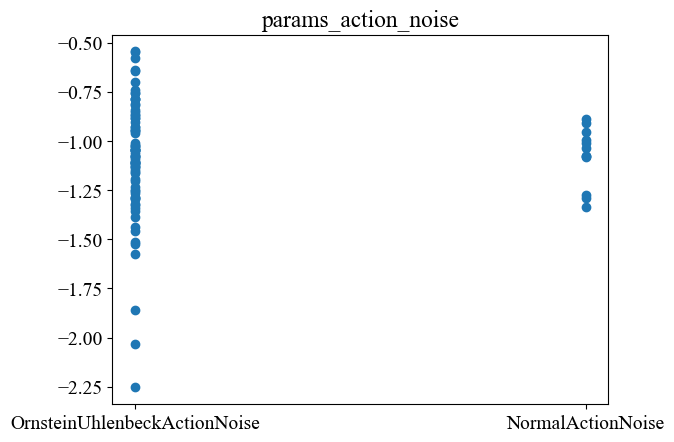

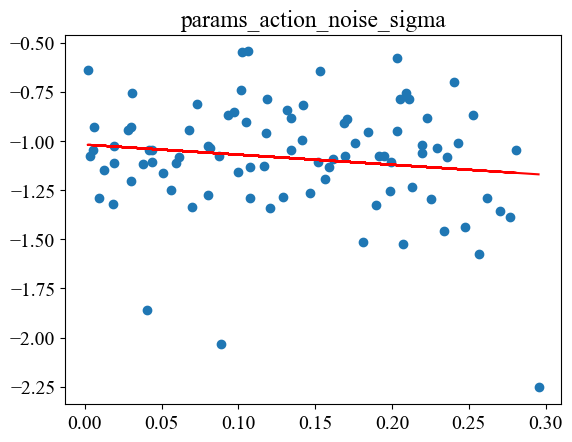

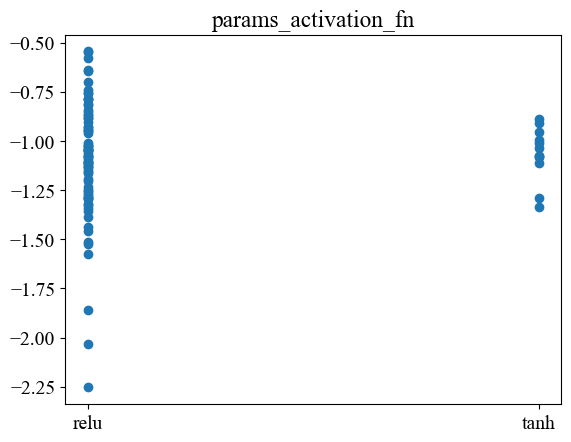

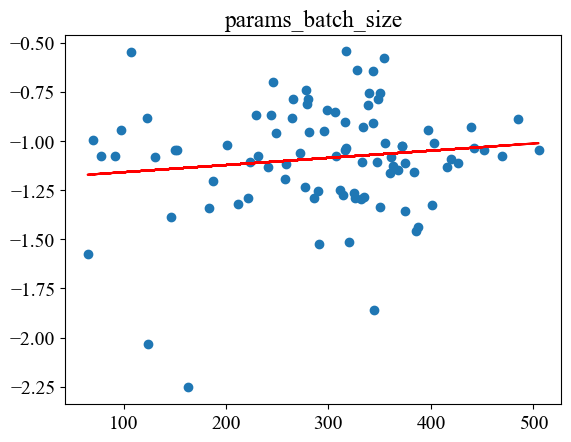

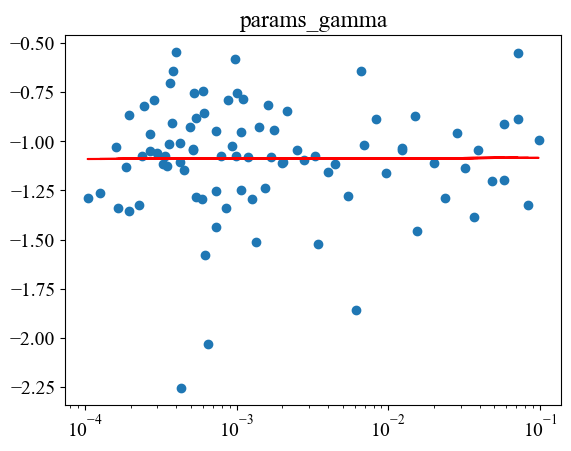

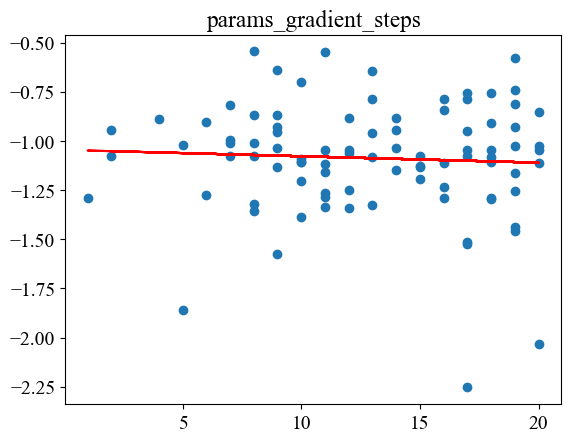

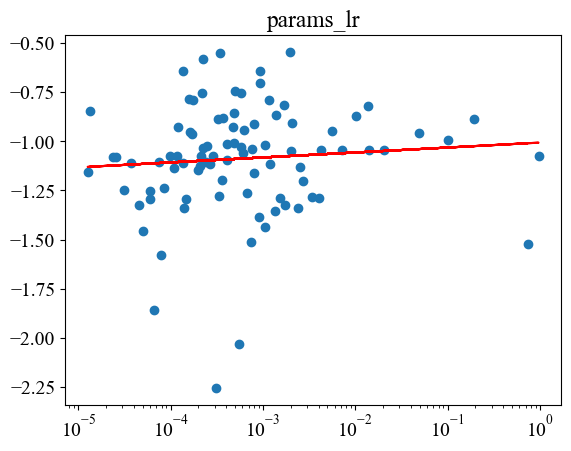

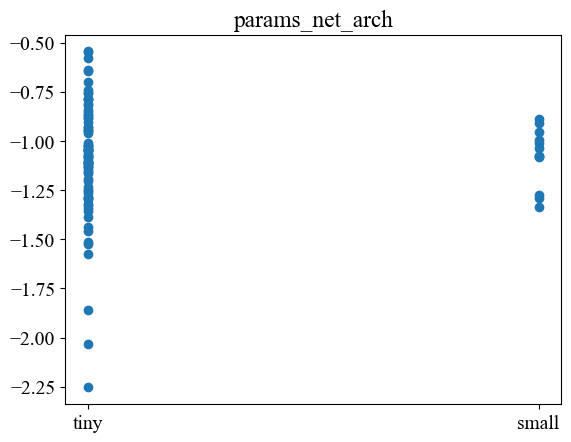

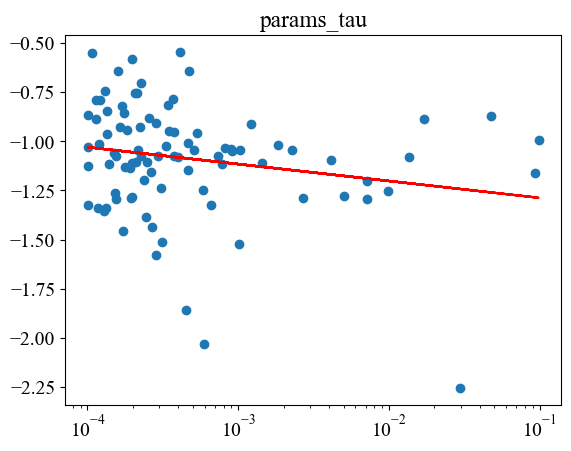

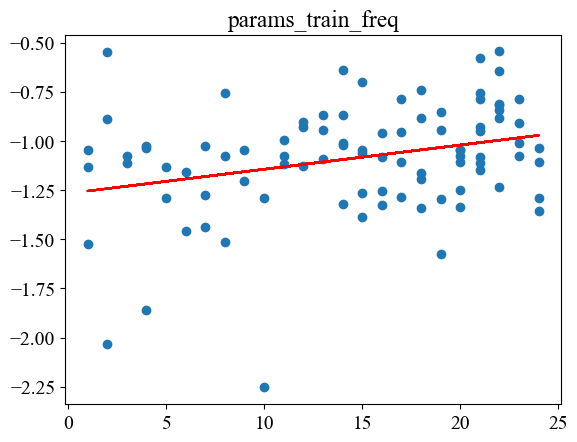

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

log_param_list = ['params_lr', 'params_gamma', 'params_tau']

for column in study_df.columns:
    if column.startswith("params_"):
        param_df = study_df[study_df[column].notna()][[column, "value"]]
        aggregated_df = param_df.groupby(column).mean().sort_values(column, ascending=False)

        plt.scatter(param_df[column], param_df["value"])
        if column in log_param_list:
            plt.xscale("log")
            
            X = np.log(param_df[column]).values.reshape(-1, 1)
            y = param_df['value'].values
            model = LinearRegression().fit(X, y)

            plt.plot(param_df[column], model.predict(X), color='red')

        elif param_df[column].dtype == 'float64' or param_df[column].dtype == 'int64':
            X = param_df[column].values.reshape(-1, 1)
            y = param_df['value'].values
            model = LinearRegression().fit(X, y)

            plt.plot(param_df[column], model.predict(X), color='red')

        plt.title(column)
        plt.show()